In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as warn
warn.filterwarnings('ignore')
from sklearn.preprocessing import RobustScaler
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Importing and Saving the BTC-USD historical price data from Yahoo Finance

In [3]:
btc_cc = yf.download("BTC-USD", start="2014-09-17", end="2025-03-31", auto_adjust=False)
btc_cc

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...,...
2025-03-26,86900.882812,86900.882812,88292.156250,85861.453125,87460.234375,26704046038
2025-03-27,87177.101562,87177.101562,87786.726562,85837.937500,86896.257812,24413471941


In [4]:
# Cleaning the multi-level column names
btc_cc.reset_index(inplace=True)
btc_cc.columns = ['_'.join(filter(None, column_name)).strip() if isinstance(column_name, tuple) else column_name for column_name in btc_cc.columns]
btc_cc.columns = [column_name.replace('_BTC-USD', '') for column_name in btc_cc.columns]
btc_cc

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20,408.903992,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21,398.821014,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...,...,...
3843,2025-03-26,86900.882812,86900.882812,88292.156250,85861.453125,87460.234375,26704046038
3844,2025-03-27,87177.101562,87177.101562,87786.726562,85837.937500,86896.257812,24413471941
3845,2025-03-28,84353.148438,84353.148438,87489.859375,83557.640625,87185.234375,34198619509
3846,2025-03-29,82597.585938,82597.585938,84567.335938,81634.140625,84352.070312,16969396135


In [ ]:
btc_cc.to_csv('btc_usd.csv', index=False)

In [5]:
btc_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3848 entries, 0 to 3847
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3848 non-null   datetime64[ns]
 1   Adj Close  3848 non-null   float64       
 2   Close      3848 non-null   float64       
 3   High       3848 non-null   float64       
 4   Low        3848 non-null   float64       
 5   Open       3848 non-null   float64       
 6   Volume     3848 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 210.6 KB


Viewing the Start and End Dates in this imported BTC historical crypto trading data

In [6]:
first_date = btc_cc['Date'].min()
last_date = btc_cc['Date'].max()

print("First trading date in this BTC historical data:", first_date.date())
print("Last trading date in this BTC historical data:", last_date.date())

First trading date in this BTC historical data: 2014-09-17
Last trading date in this BTC historical data: 2025-03-30


In [7]:
print("Minimum BTC Closing Price:", btc_cc['Close'].min())
print("Maximum BTC Closing Price:", btc_cc['Close'].max())
print("Minimum BTC Opening Price:", btc_cc['Open'].min())
print("Maximum BTC Opening Price:", btc_cc['Open'].max())
print("Lowest recorded BTC high price:", btc_cc['High'].min())
print("Highest recorded BTC high price:", btc_cc['High'].max())
print("Lowest recorded BTC low price:", btc_cc['Low'].min())
print("Highest recorded BTC low price:", btc_cc['Low'].max())
print("Lowest recorded BTC trading volume:", btc_cc['Volume'].min())
print("Highest recorded BTC trading volume:", btc_cc['Volume'].max())

Minimum BTC Closing Price: 178.10299682617188
Maximum BTC Closing Price: 106146.265625
Minimum BTC Opening Price: 176.89700317382812
Maximum BTC Opening Price: 106147.296875
Lowest recorded BTC high price: 211.7310028076172
Highest recorded BTC high price: 109114.8828125
Lowest recorded BTC low price: 171.50999450683594
Highest recorded BTC low price: 105291.734375
Lowest recorded BTC trading volume: 5914570
Highest recorded BTC trading volume: 350967941479


# Data Analysis - Visualisation

**Seasonal Decomposition of Time Series**

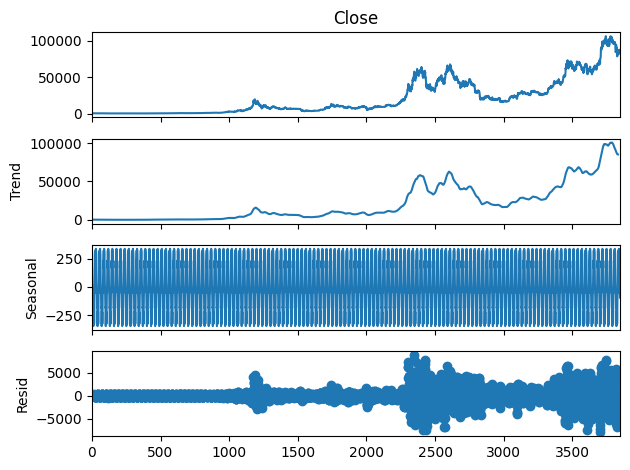

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

decom = seasonal_decompose(btc_cc['Close'], model='additive', period=30)  # 30 days for monthly pattern
decom.plot()
plt.show()

This seasonal decomposition shows a strong upward trend in Bitcoin prices, a repeating seasonal pattern with consistent cycles, and residuals indicating increased volatility in recent years. It confirms non-stationarity and the presence of both trend and seasonality components.

**Rolling data - Moving Average - Average of the past 7 days**

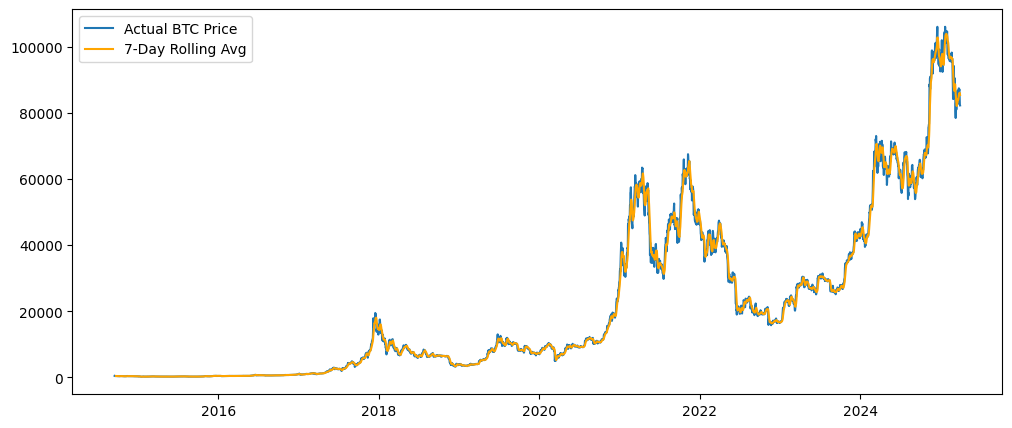

In [9]:
btc_cc['Rolling_7'] = btc_cc['Close'].rolling(window=7).mean()

plt.figure(figsize=(12,5))
plt.plot(btc_cc['Date'], btc_cc['Close'], label='Actual BTC Price')
plt.plot(btc_cc['Date'], btc_cc['Rolling_7'], label='7-Day Rolling Avg', color='orange')
plt.legend()
plt.show()

The plot compares actual Bitcoin prices with a 7-day rolling average. The rolling average smooths out short-term fluctuations, revealing the underlying trend. Both lines closely align, indicating strong short-term momentum and highlighting periodic price spikes and corrections.

**Bitcoin End-of-Month Closing Price Trend**

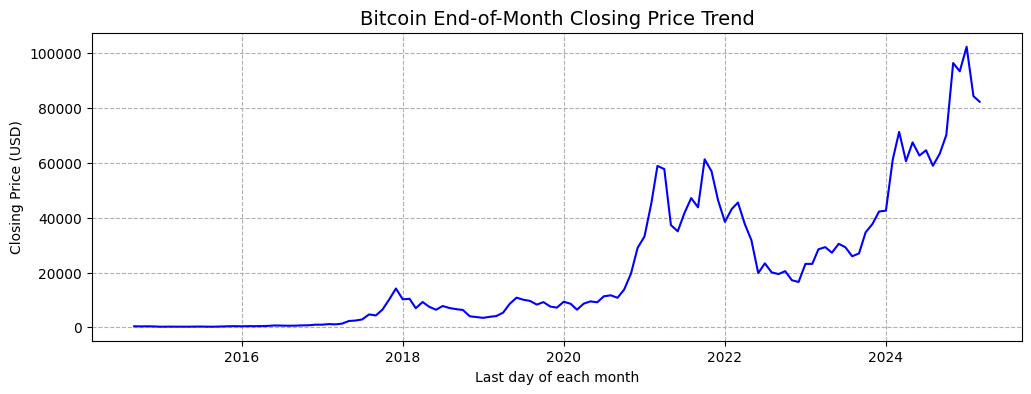

In [10]:
# Creating a new column for Year-Month and keeping the last entry of each month
btc_cc['YearMonth'] = btc_cc['Date'].dt.to_period('M')
monthly_data = btc_cc.groupby('YearMonth').last().reset_index()

# Converting YearMonth back to datetime for plotting
monthly_data['Date'] = monthly_data['YearMonth'].dt.to_timestamp()

plt.figure(figsize=(12, 4))
plt.plot(monthly_data['Date'], monthly_data['Close'], color='blue')
plt.title('Bitcoin End-of-Month Closing Price Trend', fontsize=14)
plt.xlabel('Last day of each month')
plt.ylabel('Closing Price (USD)')
plt.grid(True, linestyle='--')
plt.show()

The graph shows Bitcoins end-of-month closing price trend from 2014 to 2025. Prices remained low until 2017, followed by sharp fluctuations, peaking above $100,000 in 2024, indicating high volatility and rapid growth in recent years.

**Candle Stick Chart showing the monthly bitcoin price and the fluctuations**

In [11]:
pip install plotly

In [12]:
import plotly.graph_objects as go

# Grouping the data by year & month, and getting the last entry of each month
month_end_data = btc_cc.groupby([btc_cc['Date'].dt.to_period('M')]).agg({
    'Date': 'last', 'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'
    }).reset_index(drop=True)

# Creating the candlestick chart
Chart = go.Figure(data=[go.Candlestick(x=month_end_data['Date'],
                                       open=month_end_data['Open'],
                                       high=month_end_data['High'],
                                       low=month_end_data['Low'],
                                       close=month_end_data['Close'],
                                       increasing_line_color='green',
                                       decreasing_line_color='red')])

Chart.update_layout(title='Candlestick Chart - Monthly BTC Price',
                    xaxis_title='Last day of each month',
                    yaxis_title='BTC Price (USD)',
                    xaxis_rangeslider_visible=False)
Chart.show()

Th candlestick chart above shows monthly BTC price movements from 2014 to 2025, highlighting high volatility, sharp uptrends in 2017 and 2021, and a peak above $100,000 in 2024.

**Candle stick chart for the months Feb and March 2025**

In [13]:
feb_mar = btc_cc[(btc_cc['Date'] >= '2025-02-01') & (btc_cc['Date'] <= '2025-03-31')]

# Creating the candlestick chart
Chart = go.Figure(data=[go.Candlestick(x=feb_mar['Date'],
                                       open=feb_mar['Open'],
                                       high=feb_mar['High'],
                                       low=feb_mar['Low'],
                                       close=feb_mar['Close'],
                                       increasing_line_color='green',
                                       decreasing_line_color='red')])

Chart.update_layout(title='Candlestick Chart - Daily BTC Price- Feb & March 2025',
                    xaxis_title='Date',
                    yaxis_title='BTC Price (USD)',
                    xaxis_rangeslider_visible=False)
Chart.show()

The candlestick above shows daily BTC price fluctuations from Feb to March 2025. The price fell from over $100k to around $85k, followed by minor recovery and sideways consolidation near month-end.

**Checking whether data is stationery or not stationery and if found stationery then applying Differencing**

In [14]:
from statsmodels.tsa.stattools import adfuller

#Extracting the closing btc price series
closing_series = btc_cc['Close']

#Making the btc series to stationary (apply differencing if needed)
def btc_stationary(series, max_diffs=2):
    initial_btc_series = series.dropna().copy()
    difference_applied = 0

    for i in range(max_diffs + 1):
        result = adfuller(initial_btc_series)
        p_value = result[1]

        print(f"\nAugmented Dickey-Fuller (ADF) Test{i+1}:")
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {p_value:.4f}")
        if p_value <= 0.05:
            print("Bitcoin series is now stationary")
            return initial_btc_series, difference_applied
        elif i < max_diffs:
            print("Bitcoin series is not stationary. Applying differencing...")
            initial_btc_series = pd.Series(np.diff(initial_btc_series), index=initial_btc_series.index[1:])
            difference_applied += 1

    raise ValueError("Could not make the Bitcoin series stationary")

try:
    print("Checking stationarity of original BTC closing price series...")
    close_stationary, difference_needed = btc_stationary(btc_cc['Close'])

    print(f"\n Successfully made series stationary with {difference_needed} difference(s)")
    print("Proceeding with next steps...")

    # Replace the original closing prices with the stationary version
    btc_cc = btc_cc.iloc[difference_needed:]  # Align with differencing
    btc_cc['Close'] = close_stationary.values

except ValueError as e:
    print(f"\n Error: {e}")
    print(" Cannot proceed with analysis - Bitcoin series is not stationary")

Checking stationarity of original BTC closing price series...

Augmented Dickey-Fuller (ADF) Test1:
ADF Statistic: -0.5211
p-value: 0.8878
Bitcoin series is not stationary. Applying differencing...

Augmented Dickey-Fuller (ADF) Test2:
ADF Statistic: -9.2114
p-value: 0.0000
Bitcoin series is now stationary

 Successfully made series stationary with 1 difference(s)
Proceeding with next steps...


# **Sliding window one-step ahead forecasting**

In [15]:
closing_prices = btc_cc['Close'].values
dates = btc_cc['Date'].values

# In this code 10 previous days will be used to predict the next day's price
window_size = 10

# Preparing the input (X), target (y), and target date using a sliding window
X, y, y_dates = [], [], []
for current_day_index in range(window_size, len(closing_prices)):
    ten_days_window = closing_prices[current_day_index - window_size:current_day_index]  # previous 10 days
    target_day = closing_prices[current_day_index]  # next day's price
    target_date = dates[current_day_index]  # next day's date

    X.append(ten_days_window)
    y.append(target_day)
    y_dates.append(target_date)

X = np.array(X)
y = np.array(y)
y_dates = np.array(y_dates)

print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print("Example input:", X[0])
print("Expected output:", y[0])

# Reshaping X
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"Reshaped input for LSTM: {X.shape}")

Input shape (X): (3837, 10)
Target shape (y): (3837,)
Example input: [-32.89401245 -29.64401245  14.10800171 -10.08297729   3.33099365
  33.63897705 -12.58599854 -11.63098145  -7.14901733  -4.90499878]
Expected output: -22.3389892578125
Reshaped input for LSTM: (3837, 10, 1)


**DAta Splitting into Training and Testing**

In [16]:
split_date = np.datetime64('2025-01-01')
before_split_date = y_dates < split_date
from_2025_onward = y_dates >= split_date

# Splitting the dataset in to training and testing
X_train, X_test = X[before_split_date], X[from_2025_onward]
y_train, y_test = y[before_split_date], y[from_2025_onward]

print(f"\nTraining set of BTC closing prices:  X = {X_train.shape},  y = {y_train.shape}")
print(f"Testing set of BTC closing prices:   X = {X_test.shape},   y = {y_test.shape}")


Training set of BTC closing prices:  X = (3748, 10, 1),  y = (3748,)
Testing set of BTC closing prices:   X = (89, 10, 1),   y = (89,)


In [17]:
X_train

array([[[-3.28940125e+01],
        [-2.96440125e+01],
        [ 1.41080017e+01],
        ...,
        [-1.16309814e+01],
        [-7.14901733e+00],
        [-4.90499878e+00]],

       [[-2.96440125e+01],
        [ 1.41080017e+01],
        [-1.00829773e+01],
        ...,
        [-7.14901733e+00],
        [-4.90499878e+00],
        [-2.23389893e+01]],

       [[ 1.41080017e+01],
        [-1.00829773e+01],
        [ 3.33099365e+00],
        ...,
        [-4.90499878e+00],
        [-2.23389893e+01],
        [-1.71398926e+00]],

       ...,

       [[-2.55058594e+03],
        [ 2.64976562e+02],
        [-5.31203125e+02],
        ...,
        [-3.50367969e+03],
        [-1.63065625e+03],
        [ 9.99070312e+02]],

       [[ 2.64976562e+02],
        [-5.31203125e+02],
        [-2.11978906e+03],
        ...,
        [-1.63065625e+03],
        [ 9.99070312e+02],
        [-1.63370312e+03]],

       [[-5.31203125e+02],
        [-2.11978906e+03],
        [-4.18695312e+02],
        ...,
        

In [18]:
y_test

array([  990.5546875,  2467.1171875,  1220.5546875,   128.796875 ,
          78.734375 ,  3763.125    , -5155.3828125, -1879.1796875,
       -2559.484375 ,  2217.4140625,  -134.859375 ,   -78.15625  ,
          28.0859375,  2017.5234375,  3970.4453125,  -747.5859375,
        4705.1328125,   -53.96875  , -3318.4609375,   927.0546875,
        4129.6015625, -2493.1953125,   307.1015625,   859.3125   ,
        -104.8359375, -2032.1484375,  -594.8125   ,  -755.2109375,
        2370.734375 ,  1032.09375  , -2330.28125  , -1749.1171875,
       -2966.9296875,  3716.4453125, -3533.6015625, -1256.375    ,
         -22.1484375,   -64.2109375,   -46.6328125,    17.640625 ,
         937.4609375, -1690.125    ,  2138.4296875, -1261.9921875,
         885.1015625,    71.3828125, -1405.3203125,  -401.6484375,
        -233.8359375,  1096.0625   ,  1698.328125 , -2208.390625 ,
         452.2109375,  -303.8359375, -4855.75     , -2682.       ,
       -4389.1484375,   357.203125 ,  -331.21875  ,  1658.9062

# **Unidirectional LSTM**

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 580421.8125 - mae: 343.8010 - val_loss: 1888092.1250 - val_mae: 866.4393
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 646352.6875 - mae: 360.4703 - val_loss: 1900366.1250 - val_mae: 865.1318
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 628954.8750 - mae: 361.2101 - val_loss: 1893873.1250 - val_mae: 868.6414
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 646250.4375 - mae: 352.6404 - val_loss: 1900795.3750 - val_mae: 869.2023
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 608215.2500 - mae: 355.7656 - val_loss: 1894628.8750 - val_mae: 864.9390
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 701962.5000 - mae: 375.9767 - val_loss: 1926677.1250 - val_mae: 876.3591
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 609079.2500 - mae: 361.9410 - val_loss: 1928143.3750 - val_mae: 871.6175
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 610943.9375 - m

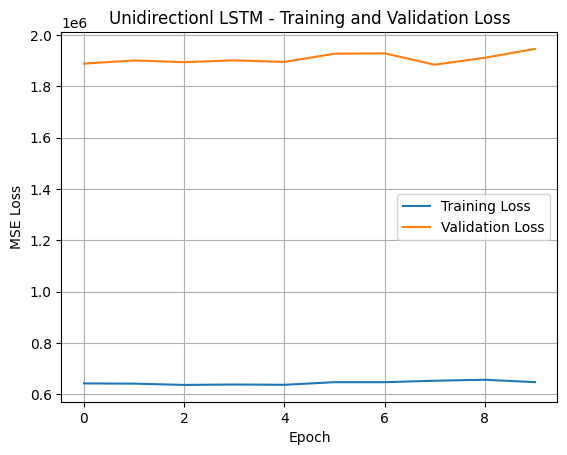

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step

 Metrics: Unidirectional LSTM:
MAE  - 16694.1085
MSE  - 314788515.6402
RMSE - 17742.2805
R²   - -4.8421
MAPE - 332.62%



In [19]:
# Building Uni-directional LSTM model for next-day price prediction
Uni_LSTM = Sequential()
Uni_LSTM.add(LSTM(300, activation='selu', input_shape=(window_size, 1)))
Uni_LSTM.add(Dense(1))
Uni_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Uni-LSTM model
history_uni_lstm = Uni_LSTM.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_uni_lstm.history['loss'], label='Training Loss')
plt.plot(history_uni_lstm.history['val_loss'], label='Validation Loss')
plt.title('Unidirectionl LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = Uni_LSTM.predict(X_test).flatten()

# Inverse differencing
last_train_price = btc_cc['Close'].iloc[len(btc_cc) - len(y_test) - 1]
y_pred_inverse = np.r_[last_train_price, y_pred].cumsum()[1:]
y_test_inverse = np.r_[last_train_price, y_test].cumsum()[1:]

print(f"\n Metrics: Unidirectional LSTM:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Unidirectionl LSTM

Sample 1
Last 10 days input (closing btc price): [-2119.7890625  -418.6953125  3989.8515625   623.1015625 -3503.6796875
 -1630.65625     999.0703125 -1633.703125   -887.015625    785.9921875]
Actual BTC closing price      : 1776.546875
Predicted BTC closing price   : 399.19976806640625

Sample 2
Last 10 days input (closing btc price): [ -418.6953125  3989.8515625   623.1015625 -3503.6796875 -1630.65625
   999.0703125 -1633.703125   -887.015625    785.9921875   990.5546875]
Actual BTC closing price      : 4243.6640625
Predicted BTC closing price   : -7.06903076171875

Sample 3
Last 10 days input (closing btc price): [ 3989.8515625   623.1015625 -3503.6796875 -1630.65625     999.0703125
 -1633.703125   -887.015625    785.9921875   990.5546875  2467.1171875]
Actual BTC closing price      : 5464.21875
Predicted BTC closing price   : -559.3731689453125

Sample 4
Last 10 days input (closing btc price): [  623.1015625 -3503.6796875 -1630.65625    

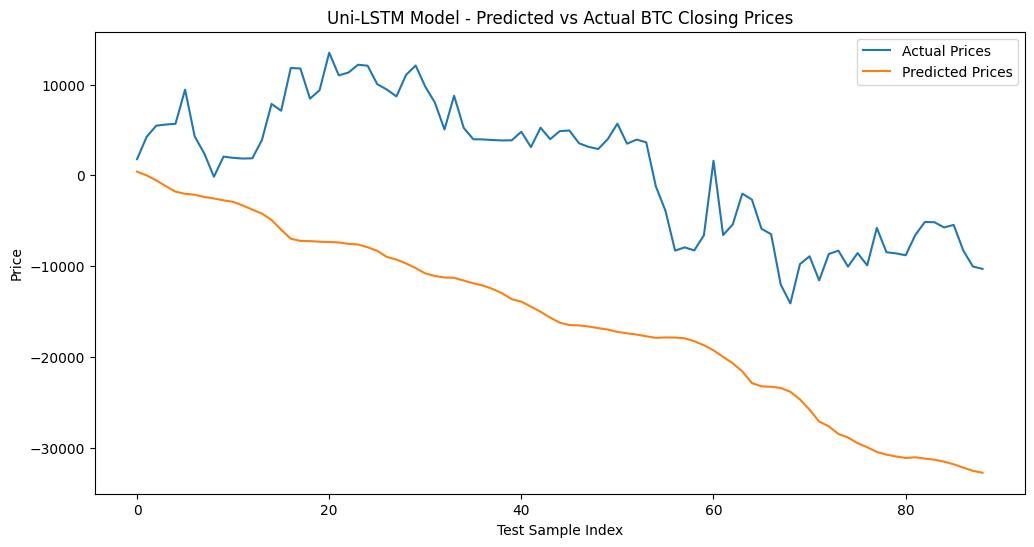

In [20]:
print("\nSome test predictions of Unidirectionl LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Uni-LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Bidirectional LSTM**

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 608165.6875 - mae: 357.7322 - val_loss: 1908099.6250 - val_mae: 870.4804
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 525984.3750 - mae: 330.2305 - val_loss: 1914727.8750 - val_mae: 870.5055
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 680524.5000 - mae: 377.5982 - val_loss: 1904915.6250 - val_mae: 879.1939
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 673014.6875 - mae: 363.0235 - val_loss: 1918782.5000 - val_mae: 876.4315
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 623619.1250 - mae: 358.4098 - val_loss: 1906343.3750 - val_mae: 867.5643
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 576550.5625 - mae: 346.6602 - val_loss: 1902589.1250 - val_mae: 871.9338
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 670522.0000 - mae: 375.3367 - val_loss: 1935047.6250 - val_mae: 882.1354
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 558914.0625 

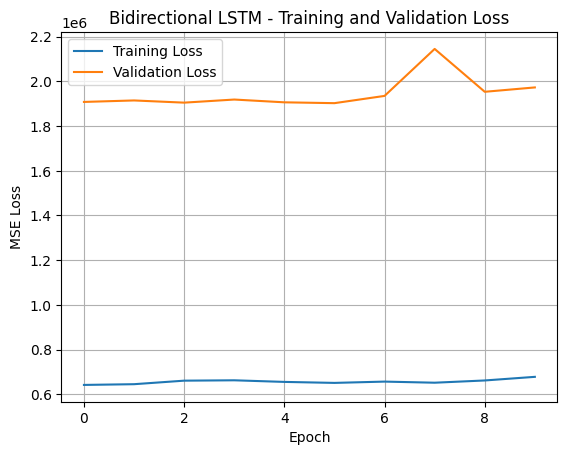

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step

 Metrics: Bidirectional LSTM:
MAE  - 15469.3907
MSE  - 413170716.4604
RMSE - 20326.6012
R²   - -6.6679
MAPE - 294.20%



In [22]:
# Building Bi-directional LSTM model for next-day price prediction
Bi_LSTM = Sequential()
Bi_LSTM.add(Bidirectional(LSTM(300, activation='selu', input_shape=(window_size, 1))))
Bi_LSTM.add(Dense(1))
Bi_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Bi-LSTM model
history_bi_lstm = Bi_LSTM.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_bi_lstm.history['loss'], label='Training Loss')
plt.plot(history_bi_lstm.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = Bi_LSTM.predict(X_test).flatten()

# Inverse differencing
last_train_price = btc_cc['Close'].iloc[len(btc_cc) - len(y_test) - 1]
y_pred_inverse = np.r_[last_train_price, y_pred].cumsum()[1:]
y_test_inverse = np.r_[last_train_price, y_test].cumsum()[1:]

print(f"\n Metrics: Bidirectional LSTM:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Bidirectionl LSTM

Sample 1
Last 10 days input (closing btc price): [-2119.7890625  -418.6953125  3989.8515625   623.1015625 -3503.6796875
 -1630.65625     999.0703125 -1633.703125   -887.015625    785.9921875]
Actual BTC closing price      : 1776.546875
Predicted BTC closing price   : 885.5173797607422

Sample 2
Last 10 days input (closing btc price): [ -418.6953125  3989.8515625   623.1015625 -3503.6796875 -1630.65625
   999.0703125 -1633.703125   -887.015625    785.9921875   990.5546875]
Actual BTC closing price      : 4243.6640625
Predicted BTC closing price   : 1482.8782196044922

Sample 3
Last 10 days input (closing btc price): [ 3989.8515625   623.1015625 -3503.6796875 -1630.65625     999.0703125
 -1633.703125   -887.015625    785.9921875   990.5546875  2467.1171875]
Actual BTC closing price      : 5464.21875
Predicted BTC closing price   : 2640.9298553466797

Sample 4
Last 10 days input (closing btc price): [  623.1015625 -3503.6796875 -1630.65625     

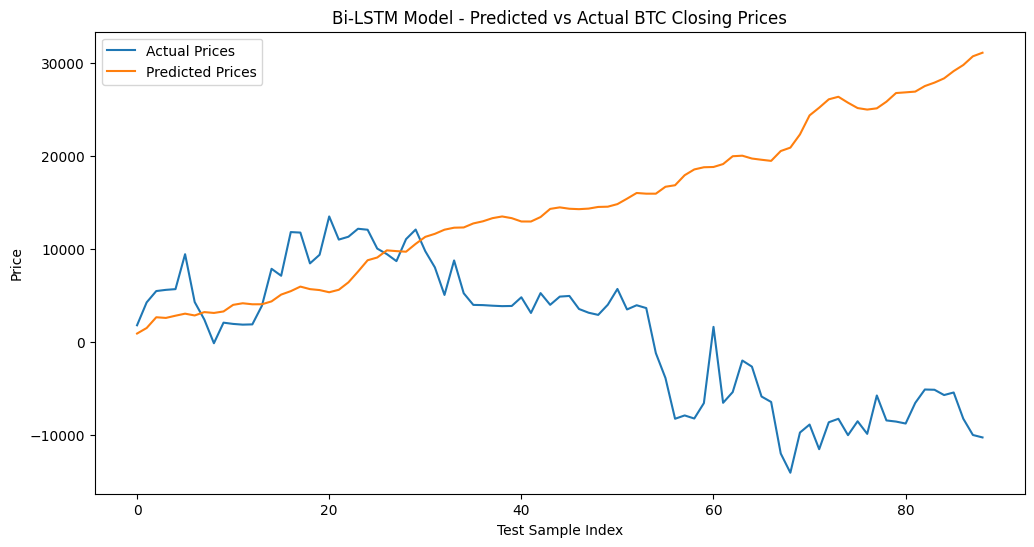

In [23]:
print("\nSome test predictions of Bidirectionl LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Bi-LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Stacked LSTM**

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 631085.0000 - mae: 358.7438 - val_loss: 1948686.0000 - val_mae: 876.1218
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 649037.1250 - mae: 366.2457 - val_loss: 1897124.7500 - val_mae: 876.2151
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 619228.7500 - mae: 357.7966 - val_loss: 1895798.1250 - val_mae: 872.8516
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 626576.7500 - mae: 366.6788 - val_loss: 1919742.5000 - val_mae: 873.8018
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 661876.6875 - mae: 372.9272 - val_loss: 2075351.8750 - val_mae: 915.1195
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 699207.5000 - mae: 380.3735 - val_loss: 1944033.5000 - val_mae: 888.9642
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 603047.1875 - mae: 352.8858 - val_loss: 2248918.7500 - val_mae: 962.3965
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 737401.0000 - ma

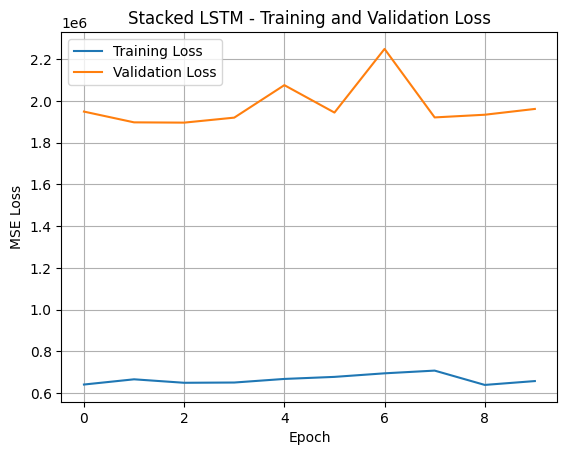

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step

 Metrics: Stacked LSTM:
MAE  - 15380.6342
MSE  - 266237640.5219
RMSE - 16316.7901
R²   - -3.9410
MAPE - 310.41%



In [24]:
# Building Stacked LSTM model for next-day price prediction
stacked_LSTM = Sequential()
stacked_LSTM.add(LSTM(300, activation='selu', return_sequences=True, input_shape=(window_size, 1)))
stacked_LSTM.add(LSTM(150, activation='selu'))
stacked_LSTM.add(Dense(1))
stacked_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Stacked LSTM model
history_stacked_lstm = stacked_LSTM.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_stacked_lstm.history['loss'], label='Training Loss')
plt.plot(history_stacked_lstm.history['val_loss'], label='Validation Loss')
plt.title('Stacked LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = stacked_LSTM.predict(X_test).flatten()

# Inverse differencing
last_train_price = btc_cc['Close'].iloc[len(btc_cc) - len(y_test) - 1]
y_pred_inverse = np.r_[last_train_price, y_pred].cumsum()[1:]
y_test_inverse = np.r_[last_train_price, y_test].cumsum()[1:]

print(f"\n Metrics: Stacked LSTM:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Checking some test predictions - Stacked LSTM

Sample 1
Last 10 days input (closing price): [-2119.7890625  -418.6953125  3989.8515625   623.1015625 -3503.6796875
 -1630.65625     999.0703125 -1633.703125   -887.015625    785.9921875]
Actual BTC closing price      : 1776.546875
Predicted BTC closing price   : 485.6139221191406

Sample 2
Last 10 days input (closing price): [ -418.6953125  3989.8515625   623.1015625 -3503.6796875 -1630.65625
   999.0703125 -1633.703125   -887.015625    785.9921875   990.5546875]
Actual BTC closing price      : 4243.6640625
Predicted BTC closing price   : -148.67422485351562

Sample 3
Last 10 days input (closing price): [ 3989.8515625   623.1015625 -3503.6796875 -1630.65625     999.0703125
 -1633.703125   -887.015625    785.9921875   990.5546875  2467.1171875]
Actual BTC closing price      : 5464.21875
Predicted BTC closing price   : -997.0961608886719

Sample 4
Last 10 days input (closing price): [  623.1015625 -3503.6796875 -1630.65625     999.0703125 

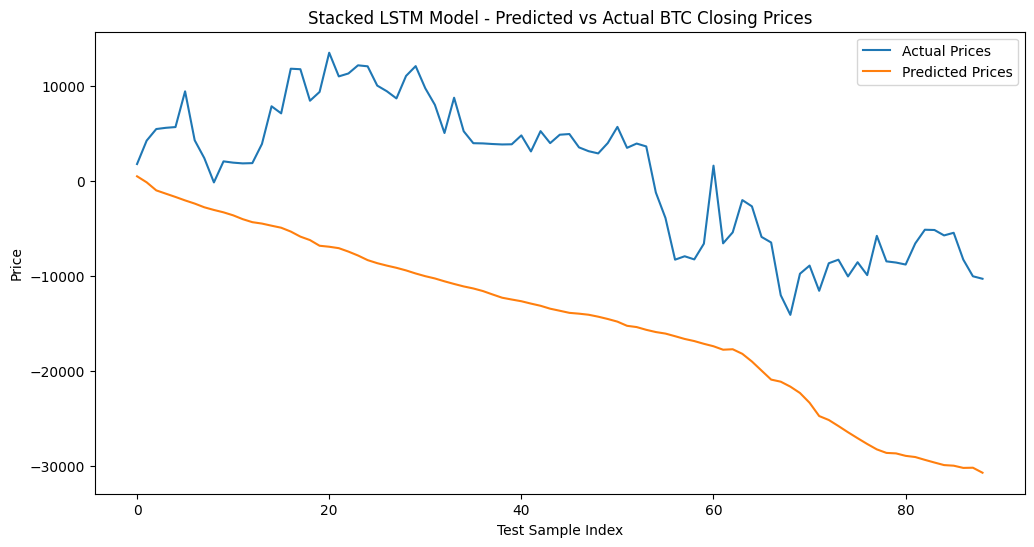

In [25]:
print("\nChecking some test predictions - Stacked LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing price):", X_test[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Stacked LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()